In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmos
h = cosmos.H0.value/100
from astropy.io import fits
import healpy as hp

In [114]:
# f = fits.open('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS_eBOSS_weight_maps/SDSS_WISE_imageprop_nside512.fits')
f = fits.open('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS_eBOSS_weight_maps/SDSSimageprop_Nside512.fits')

In [115]:
f[1].data

FITS_rec([(0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          ...,
          (0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan),
          (0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan)],
         dtype=(numpy.record, [('NRAN', '>f8'), ('SKY_G', '>f8'), ('SKY_R', '>f8'), ('SKY_I', '>f8'), ('SKY_Z', '>f8'), ('AIRMASS', '>f8'), ('EBV', '>f8'), ('DEPTH_G', '>f8'), ('DEPTH_R', '>f8'), ('DEPTH_I', '>f8'), ('DEPTH_Z', '>f8'), ('PSF_G', '>f8'), ('PSF_R', '>f8'), ('PSF_I', '>f8'), ('PSF_Z', '>f8')]))

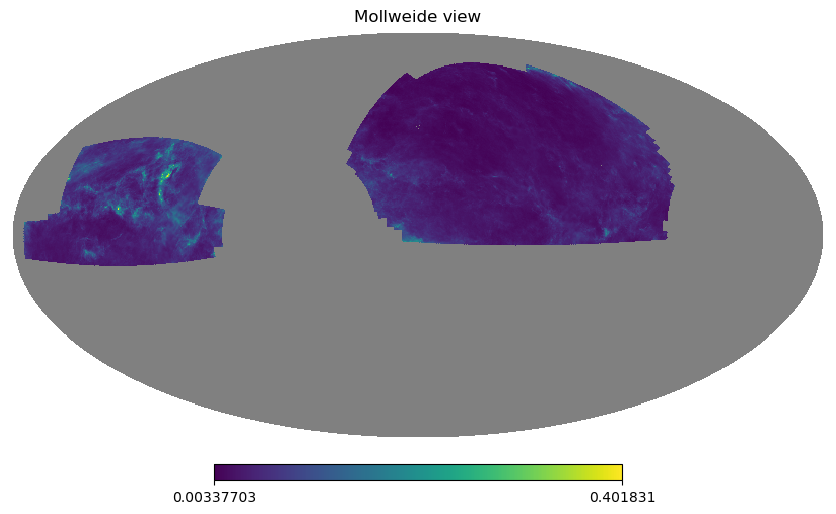

In [116]:
hp.mollview(f[1].data['EBV'], rot=(-130, 0, 0))
# hp.graticule()

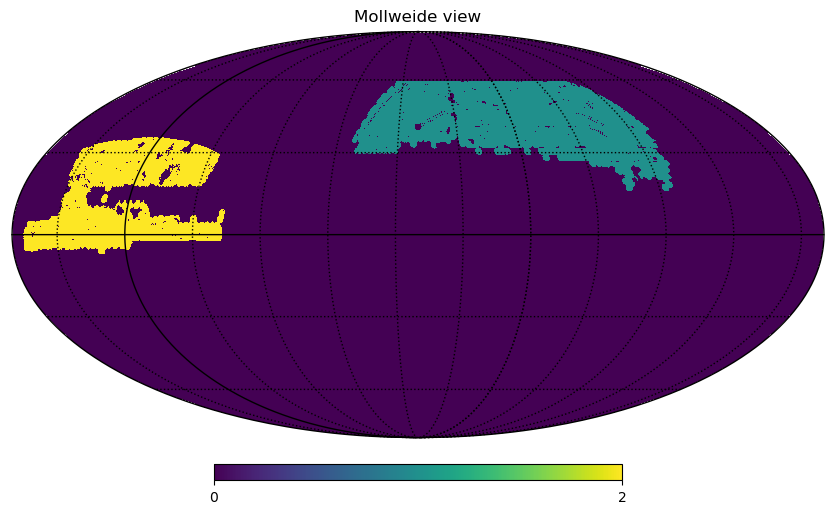

In [88]:
image = np.zeros_like(f[1].data['EBV'])

pix_r = hp.ang2pix(Nside, np.deg2rad(90 - random_n['DEC']), np.deg2rad(random_n['RA']))
pix_ur = np.unique(pix_r)
image[pix_ur] = 1

pix_r = hp.ang2pix(Nside, np.deg2rad(90 - random_s['DEC']), np.deg2rad(random_s['RA']))
pix_ur = np.unique(pix_r)
image[pix_ur] = 2

hp.mollview(image, rot=(-130, 0, 0))
hp.graticule()

In [90]:
# data = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS_eBOSS_weight_maps/SDSS_WISE_imageprop_nside512.fits')
data = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS_eBOSS_weight_maps/SDSSimageprop_Nside512.fits')

In [3]:
random_n = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_random-NGC-vDR16.fits')
random_s = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_random-SGC-vDR16.fits')
random_all = np.hstack((random_n, random_s))

In [4]:
quasar_n = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-NGC-vDR16.fits')
quasar_s = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/eBOSS_QSO_clustering_data-SGC-vDR16.fits')
quasar_all = np.hstack((quasar_n, quasar_s))

In [5]:
Nside = 512
Npix = hp.nside2npix(Nside)
print(f'scale: {hp.nside2resol(Nside, True)} arcmin')

scale: 6.870972823634812 arcmin


In [95]:
quasar_cata = quasar_n
random_cata = random_n

In [96]:
pix = hp.ang2pix(Nside, np.deg2rad(90 - quasar_cata['dec']), np.deg2rad(quasar_cata['ra']))

pix_r = hp.ang2pix(Nside, np.deg2rad(90 - random_cata['DEC']), np.deg2rad(random_cata['RA']))
pix_ur = np.unique(pix_r)

In [97]:
count = np.bincount(pix, minlength=Npix)                                            # number count in each area

Nbins = 10
bin_edge = np.linspace(0, 0.15, Nbins+1, True)
bin_center = (bin_edge[1:] + bin_edge[:-1])/2

In [98]:
# random pixels
count_all = count[pix_ur]
Ebv = data['EBV'][pix_ur]
depth_g = data['DEPTH_G'][pix_ur]
sky_i = data['SKY_I'][pix_ur]
psf_i = data['PSF_I'][pix_ur]

valid = ~(np.isnan(Ebv) | np.isnan(depth_g) | np.isnan(sky_i) | np.isnan(psf_i))

In [99]:
count_all = count_all[valid]
Ebv = Ebv[valid]
depth_g = depth_g[valid]
sky_i = sky_i[valid]
psf_i = psf_i[valid]

density = count_all / count_all.mean()

In [100]:
outliers = np.zeros(len(density), bool)
for feature in [Ebv, depth_g, sky_i, psf_i]:
    _min, _max = np.percentile(feature, [0.5, 99.5])
    outliers |= ((feature < _min) | (feature > _max))

In [101]:
valid = ~outliers
density = density[valid]
Ebv = Ebv[valid]
depth_g = depth_g[valid]
sky_i = sky_i[valid]
psf_i = psf_i[valid]

In [102]:
from sklearn.linear_model import LinearRegression

In [103]:
regress = LinearRegression()
regress.fit(np.c_[depth_g, Ebv, sky_i, psf_i], density)

LinearRegression()

In [104]:
regress.intercept_

1.3187777394142817

In [105]:
regress.coef_

array([-0.14722511, -2.74731792, -0.00645748, -0.1073735 ])

In [106]:
width = [1.5, 0.15, 15, 1.6]
regress.coef_*width

array([-0.22083767, -0.41209769, -0.09686216, -0.1717976 ])

In [16]:
import seaborn as sns

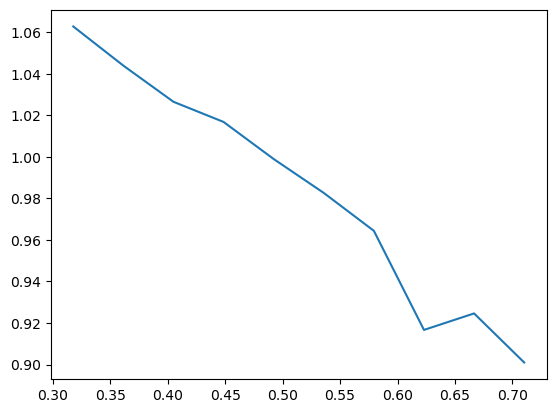

In [80]:
feature = depth_g
sep_m = feature.min()
sep_M = feature.max()
Nbins = 10

bin_edge = np.linspace(sep_m, sep_M, Nbins+1, True)
dig_res = np.digitize(feature, bin_edge)
x = (bin_edge[1:]+bin_edge[:-1])/2
y = []
for i in range(1, Nbins+1):
    y.append(density[dig_res == i].mean())
plt.plot(x, y)

<Axes: ylabel='Count'>

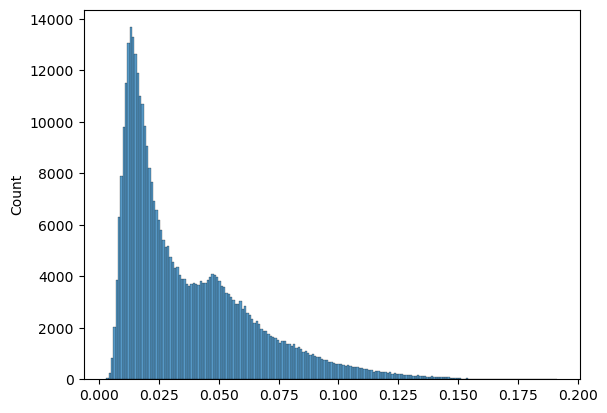

In [29]:
sns.histplot(Ebv.astype(float))

<Axes: ylabel='Count'>

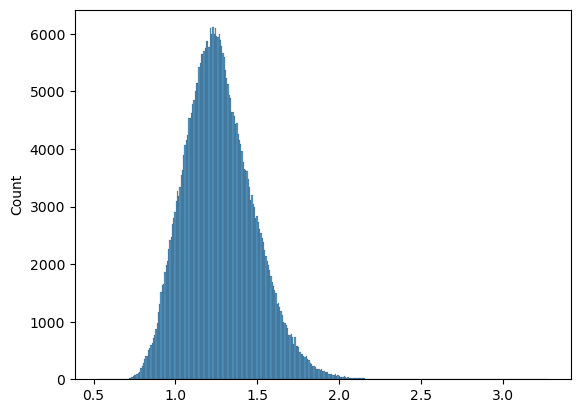

In [28]:
sns.histplot(psf_i.astype(float))

<Axes: ylabel='Count'>

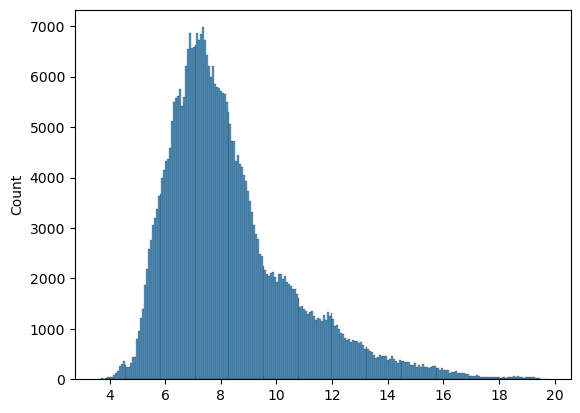

In [27]:
sns.histplot(sky_i.astype(float))

<Axes: ylabel='Count'>

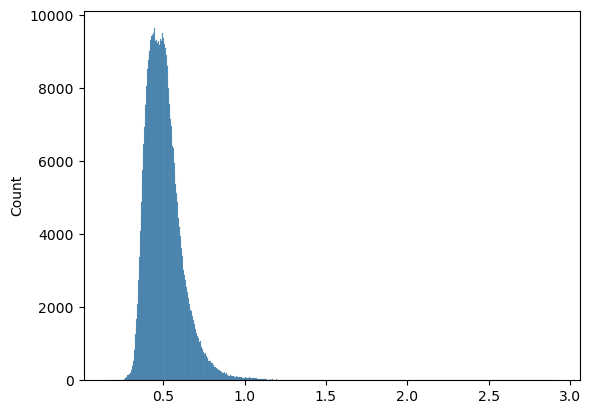

In [94]:
sns.histplot(f[1].data['DEPTH_G'].astype(float))